In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random   # Only used for uniform RNG

# Inital data
strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
prices = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
risk_free_rate = 0.002
spot = 100

## Black-Scholes price

In [294]:
# Black-Scholes price function
#
# Returns a dictionary containing the price and the greeks of the option
def BS_price(spot, strike, time_to_maturity, r, vol):
    d1 = (np.log(spot / strike) + (r + vol**2 / 2) * (time_to_maturity)) / (vol * np.sqrt(time_to_maturity))
    d2 = d1 - vol * np.sqrt(time_to_maturity)

    price = spot * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (vol * spot * np.sqrt(time_to_maturity))
    vega = spot * np.sqrt(time_to_maturity) * norm.pdf(d1) 
    theta = -spot * norm.pdf(d1) * vol / (2 * np.sqrt(time_to_maturity)) - r * strike * np.exp(-r * time_to_maturity) * norm.cdf(d2) 
    dual_delta = - np.exp(-r * time_to_maturity) * norm.cdf(d2)
    dual_gamma = -np.exp(-r * time_to_maturity) * norm.pdf(d2) / (strike * vol * np.sqrt(time_to_maturity))
    option_parameters = {'price': price, 'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'dual delta': dual_delta, 'dual gamma': dual_gamma}

    return option_parameters

# Test:
test_option_par = BS_price(100, 110, 1, 0, 0.2)
print(f'Price: { test_option_par["price"] }') # Should be $4.29
print(f'Delta: { test_option_par["delta"] }') # Should be 0.353
print(f'Gamma: { test_option_par["gamma"] }') # Should be 0.019
print(f'Vega: { test_option_par["vega"] }')   # Should be 37.164
print(f'Theta: { test_option_par["theta"] }')  # Should be -3.716


Price: 4.292010941409885
Delta: 0.35325369152806296
Gamma: 0.018581922182971666
Vega: 37.16384436594333
Theta: -3.7163844365943337


## Implied volatility from BS price

In [295]:
# Returns the implied volatility using Newton-Raphson algorithm
def get_implied_vol(spot, strike, time_to_maturity, r, starting_vol, market_price):
    old_vol = 0
    new_vol = starting_vol
    iterations = 1
    while abs(old_vol - new_vol) > 1E-8 and iterations < 1E3 :
        old_vol = new_vol
        opt_parameters = BS_price(spot, strike, time_to_maturity, r, old_vol)
        new_vol = old_vol - (opt_parameters["price"] - market_price) / opt_parameters["vega"]
        iterations += 1
    return new_vol

# Test:
test_implied_vol = get_implied_vol(100, 110, 1, 0.002, 0.2, 6.00)
print(f'Implied volatility: {test_implied_vol}')
test_option_par = BS_price(100, 110, 1, 0.002, test_implied_vol)
print(f'BS price using implied vol: {test_option_par["price"]}   Actual price: 6.00')

Implied volatility: 0.24331750447956413
BS price using implied vol: 6.0   Actual price: 6.00


## Implied volatility smile

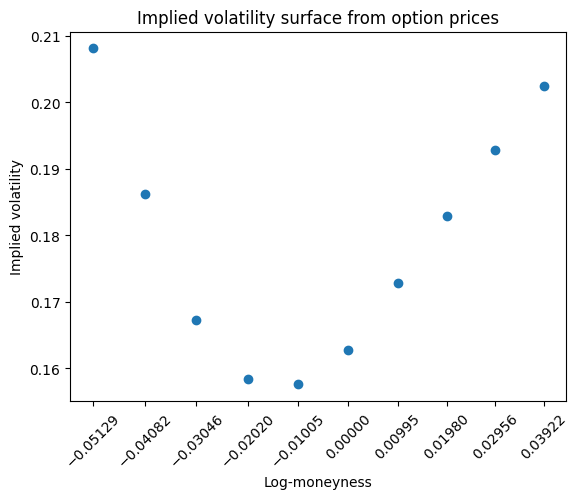

In [296]:
log_moneyness = [np.log(k / spot) for k in strikes]

# Compute the implied volatilities
implied_volatilites = []
for i in range(len(prices)):
    implied_volatilites.append(get_implied_vol(spot, strikes[i], 1, risk_free_rate, 0.2, prices[i]))

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Implied volatility surface from option prices")
ax.set_xticks(log_moneyness)
ax.tick_params(axis='x', rotation=45)
ax.scatter(log_moneyness, implied_volatilites)
plt.show()

## Estimation of the SVI
#### Definition of the SVI and gSVI formulas

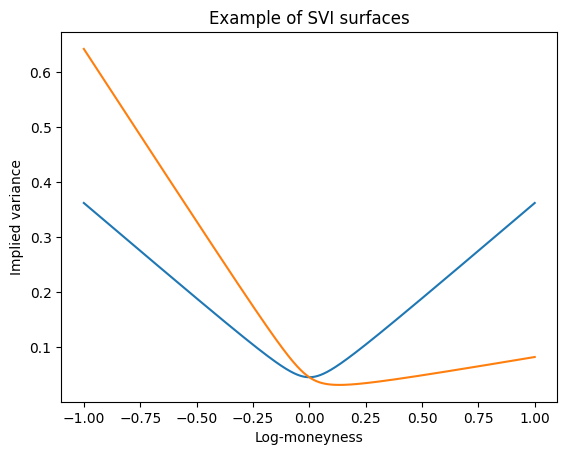

In [297]:
# Definition of the Stochastic Volatility Inspired (SVI) formula
def SVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            v = par["a"] + par["b"] * (par["rho"] * (x - par["m"]) + np.sqrt((x - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        value = par["a"] + par["b"] * (par["rho"] * (values - par["m"]) + np.sqrt((values - par["m"])**2 + par["sigma"]**2))
    return value

# Definition of the generalized Stochastic Volatility Inspired (gSVI) formula
def gSVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            z = x / par["beta"]**(abs(x - par["m"]))
            v = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        z = values / par["beta"]**(abs(values - par["m"]))
        value = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
    return value

# Test
fig, ax = plt.subplots()
x_axis = np.linspace(-1, 1, 1000)

# Different combinations of parameters
pars = {'a': 0.01, 'b': 0.35, 'rho': 0, 'm': 0, 'sigma': 0.1}
pars2 = {'a': 0.01, 'b': 0.35, 'rho': -0.8, 'm': 0, 'sigma': 0.1}

# Computation in two different ways to test the
# behaviour of the function
svi1 = []
for n in x_axis:
    svi1.append(SVI_func(n, pars)) 
svi2 = SVI_func(x_axis, pars2) 

ax.set_title("Example of SVI surfaces")
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, svi1)
ax.plot(x_axis, svi2)

plt.show()

#### Simulated Annealing

In [298]:
def simulated_annealing(func, x_data, y_data, initial_T, max_iterations):
    # Generate the initial state and compute the initial energy
    if func is SVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0.}
    elif func is gSVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0., 'beta': 1.1}
    
    previous_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)

    optimal_parameters = new_parameters.copy()
    iteration = 1
    T = initial_T

    # While we are above the minimum temperature
    while iteration < max_iterations:

        # Generate a new state randomly
        if func is SVI_func:
            n = random.randint(1, 5)
        elif func is gSVI_func:
            n = random.randint(1, 6)

        if n == 1:
            # Change b
            if iteration > max_iterations / 2:
                new_parameters["b"] = optimal_parameters["b"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["b"] = random.uniform(0.75, 0.85)
        elif n == 2:
            # Change rho
            if iteration > max_iterations / 2:
                new_parameters["rho"] = optimal_parameters["rho"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["rho"] = random.uniform(-0.5, -0.35)
        elif n == 3:
            # Change m
            if iteration > max_iterations / 2:
                new_parameters["m"] = optimal_parameters["m"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["m"] = random.uniform(-0.05, 0.05)
        elif n == 4:
            # Change sigma
            if iteration > max_iterations / 2:
                new_parameters["sigma"] = optimal_parameters["sigma"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["sigma"] = random.uniform(-0.05, 0.05)
        elif n == 5:
            # Change a
            if iteration > max_iterations / 2:
                new_parameters["a"] = optimal_parameters["a"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["a"] = random.uniform(-0.05, 0.05)
        elif n == 6:
            # Change beta
            if iteration > max_iterations / 2:
                new_parameters["beta"] = optimal_parameters["beta"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["beta"] = random.uniform(1., 1.4)

        # Compute the energy of the new state
        new_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)
        delta_energy = new_energy - previous_energy

        # If the new state has a lower energy than the previous one, save it
        if acceptance_function(T, delta_energy):
            optimal_parameters = new_parameters.copy()
            previous_energy = new_energy
            print(f'Iteration: {iteration}  |  Best Energy: {pow(previous_energy, 20):.3}  |  Temperature: {T:.3e}', end="\r")

        # Reduce the temperature and increment iteration
        T = initial_T / iteration
        iteration += 1

    return optimal_parameters

# Computes the energy of the state. In this case the energy function
# (the function that should be minimized) is the sum of squared errors
def compute_energy_with_distortion(func, x_data, parameters, y_data, beta):
    estimate = func(x_data, parameters)
    energy = sum_of_err_squared(y_data, estimate)
    distorted_energy = pow(energy, 1/beta)
    return distorted_energy

# This function decides if the new state should be accepted or refuted
# according to simulated annealing decision rule
def acceptance_function(T, delta_energy):
    if delta_energy < 0:
        return True
    else:
        r = random.uniform(0, 1)

        if T < 1E-6:
            return False

        if r < np.exp(-delta_energy / T):
            return True
        else:
            return False

# Returns the sum of the squared errors
def sum_of_err_squared(true_data, estimated_data):
    diff = [(elem1 - elem2)**2 for elem1, elem2 in zip(true_data, estimated_data)]
    s = sum(diff)
    return s

#### Estimation

{'a': 0.007386432463786766, 'b': 0.7915126134339514, 'rho': -0.40739195226558206, 'm': -0.025608667490057614, 'sigma': -0.02373182052187722}
Final energy: 1.776366612387558e-07
Final energy (generalized): 1.758138549105294e-07


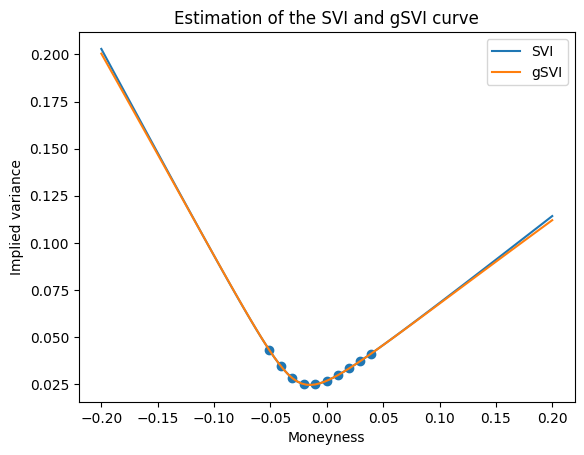

In [299]:
def compute_energy(func, x_data, parameters, y_data):
    estimate = func(x_data, parameters)
    return sum_of_err_squared(y_data, estimate)

# Fit the implied variance which is more regular, to get the volatilities
# then just do sqrt(implied_variance)
implied_variance = [v**2 for v in implied_volatilites]

# If set to True it runs the optimization algorithm, if set to False
# use the optimal parameters found previously 
if False:
    best_par = simulated_annealing(SVI_func, log_moneyness, implied_variance, 10, 2E6)
    generalized_best_par = simulated_annealing(gSVI_func, log_moneyness, implied_variance, 10, 2E6)
else:
    best_par = {'a': 0.007386432463786766, 'b': 0.7915126134339514, 'rho': -0.40739195226558206, 'm': -0.025608667490057614, 'sigma': -0.02373182052187722}
    generalized_best_par = {'a': 0.00652490563018189, 'b': 0.8134782389338896, 'rho': -0.41070426262973697, 'm': -0.02592370814631364, 'sigma': 0.024283975676713476, 'beta': 1.2028620109261117}

# Print and plot the results
print(best_par)
print(f'Final energy: {compute_energy(SVI_func, log_moneyness, best_par, implied_variance)}')
print(f'Final energy (generalized): {compute_energy(gSVI_func, log_moneyness, generalized_best_par, implied_variance)}')

x_axis = np.linspace(-0.2, 0.2, 100)

fig, ax = plt.subplots()
ax.set_title("Estimation of the SVI and gSVI curve")
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, SVI_func(x_axis, best_par))
ax.plot(x_axis, gSVI_func(x_axis, generalized_best_par))
ax.scatter(log_moneyness, implied_variance)
ax.legend(["SVI", "gSVI"])
plt.show()

## Dupire's formula

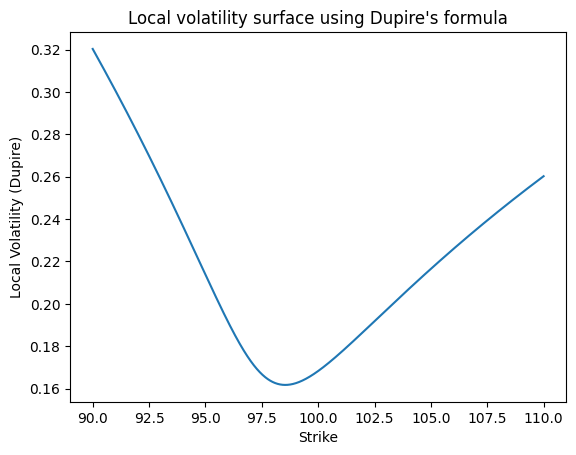

In [300]:
def Dupire_vol(strike, r, theta, dual_delta, dual_gamma):
    num = 2 * (theta + r * strike * dual_delta)
    den = strike**2 * dual_gamma
    return num / den

# Create the strike grid
strike_grid = [90 + i * 0.01 for i in range(0, 2001)]
SVI_implied_vols = [np.sqrt(SVI_func(np.log(k / spot), best_par)) for k in strike_grid]

# Compute the Dupire's volatilities
dupire_vols = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, SVI_implied_vols[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    dupire_vols.append(vol)

# Plot the results
fig, ax = plt.subplots()
ax.set_title("Local volatility surface using Dupire's formula")
ax.set_xlabel("Strike")
ax.set_ylabel("Local Volatility (Dupire)")
ax.plot(strike_grid, np.sqrt(dupire_vols))
plt.show()

## SVI Model Calibration

{'a': 0.010264046888319656, 'b': 0.821871732953936, 'rho': -0.35733861978688597, 'm': -0.018090747458748817, 'sigma': -0.018967045336479162}


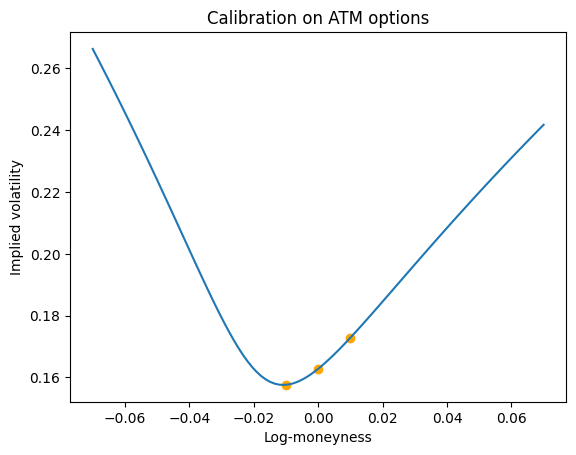

In [301]:
at_the_money_strikes = strikes[4:7]
at_the_money_prices = prices[4:7]
at_the_money_variance = implied_variance[4:7]

log_moneyness = [np.log(k / spot) for k in at_the_money_strikes]

# Calibrate the model only on the three options with closest strike to spot
if False:
    calibrated_par = simulated_annealing(SVI_func, log_moneyness, at_the_money_variance, 10, 2E6)
else:
    calibrated_par = {'a': 0.010264046888319656, 'b': 0.821871732953936, 'rho': -0.35733861978688597, 'm': -0.018090747458748817, 'sigma': -0.018967045336479162}

# Plot the results
print(calibrated_par)
x_axis = np.linspace(-0.07, 0.07, 100)

fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Calibration on ATM options")
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par)))
ax.scatter(log_moneyness, np.sqrt(at_the_money_variance), color='orange')
plt.show()

## Comparison between estimated Dupire's volatilities computed using estimated SVI surface and using calibrated SVI surface

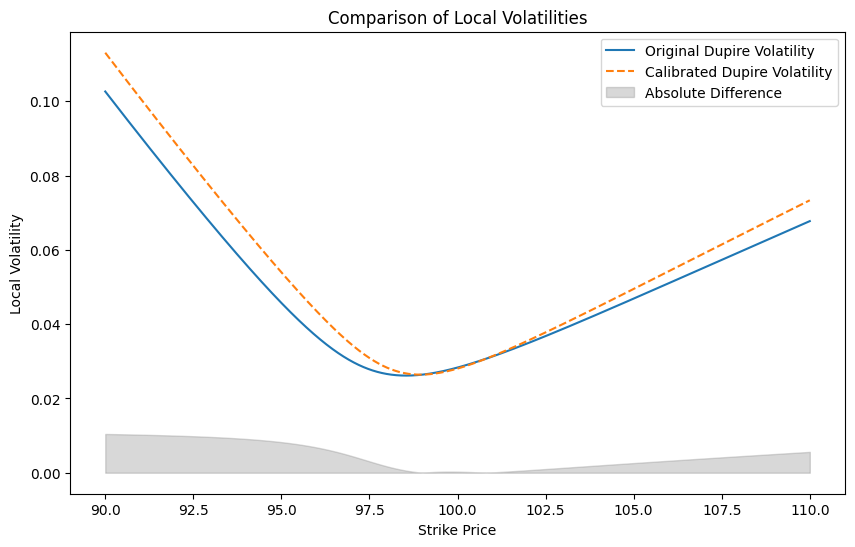

In [302]:
calibrated_SVI_implied_vols = [np.sqrt(SVI_func(np.log(k / spot), calibrated_par)) for k in strike_grid]

calibrated_dupire_vols = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, calibrated_SVI_implied_vols[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    calibrated_dupire_vols.append(vol)

vol_diff = [cal - orig for orig, cal in zip(dupire_vols, calibrated_dupire_vols)]
abs_vol_diff = [abs(dif) for dif in vol_diff]

plt.figure(figsize=(10, 6))
plt.plot(strike_grid, dupire_vols, label="Original Dupire Volatility")
plt.plot(strike_grid, calibrated_dupire_vols, label="Calibrated Dupire Volatility", linestyle='--')
plt.fill_between(strike_grid, 0, abs_vol_diff, color='gray', alpha=0.3, label="Absolute Difference")
plt.xlabel("Strike Price")
plt.ylabel("Local Volatility")
plt.title("Comparison of Local Volatilities")
plt.legend()
plt.show()

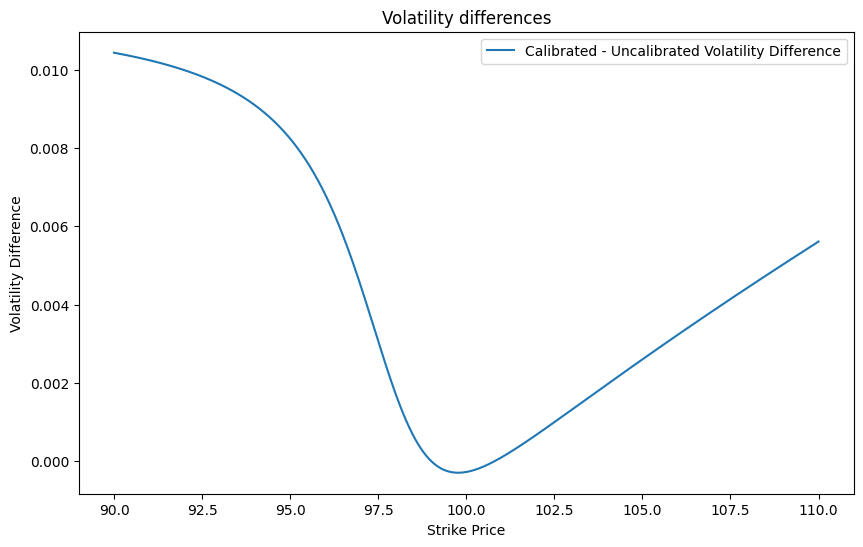

In [303]:
plt.figure(figsize=(10, 6))
plt.plot(strike_grid, vol_diff, label="Calibrated - Uncalibrated Volatility Difference")
plt.xlabel("Strike Price")
plt.ylabel("Volatility Difference")
plt.title("Volatility differences")
plt.legend()
plt.show()

## ATM price stressing and arbitrage opportunities
#### Arbitrage finder

In [304]:
# Find min and max prices for arbitrage-free condition (convexity of option prices)
def find_arbitrage_free_prices(prices, strike_index, step_size=0.001, range_size=0.05):
    original_price = prices[strike_index]
    
    min_price = original_price
    max_price = original_price
    
    for stress in np.arange(-range_size, range_size + step_size, step_size):
        new_price = original_price * (1 + stress)
        
        stressed_prices = prices[:]
        stressed_prices[strike_index] = new_price
        
        if is_arbitrage_free(stressed_prices):
            if stress < 0:
                min_price = min(new_price, min_price)  # Record the minimum price
            elif stress > 0:
                max_price = max(new_price, max_price)  # Record the maximum price
    
    return min_price, max_price
    
# Check convexity using second-order differences (butterfly arbitrage) and monotonicity (bull spread arbitrage)
def is_arbitrage_free(option_prices):
    butterfly_spreads = [
        option_prices[i + 1] - 2 * option_prices[i] + option_prices[i - 1]
        for i in range(1, len(option_prices) - 1)
    ]
    spreads = [
        option_prices[i] - option_prices[i + 1]
        for i in range(len(option_prices) - 1)
    ]
    return all(s >= 0 for s in spreads) and all(b >= 0 for b in butterfly_spreads)

min_price, max_price = find_arbitrage_free_prices(prices, strike_index=5, step_size=0.001, range_size=0.05)

print(f"Min price for arbitrage-free condition: {min_price}")
print(f"Max price for arbitrage-free condition: {max_price}")

Min price for arbitrage-free condition: 6.55368
Max price for arbitrage-free condition: 6.6852800000000006


#### Calibration with upward stress

In [305]:
# Stressed parameters up
stressed_prices_up = prices[:]
stressed_prices_up[5] = max_price

at_the_money_strikes = strikes[4:7]
at_the_money_prices = stressed_prices_up[4:7]
stressed_implied_vols_up = [
    get_implied_vol(spot, strikes[i], 1, risk_free_rate, 0.2, stressed_prices_up[i])
    for i in range(4, 7)
]
stressed_variance_up = [v**2 for v in stressed_implied_vols_up]

log_moneyness = [np.log(k / spot) for k in at_the_money_strikes]

calibrated_par_up = simulated_annealing(SVI_func, log_moneyness, stressed_variance_up, 10, 2E6)

#### Calibration with downward stress

In [306]:
# Stressed parameters down
stressed_prices_down = prices[:]
stressed_prices_down[5] = min_price

at_the_money_prices = stressed_prices_down[4:7]
stressed_implied_vols_down = [
    get_implied_vol(spot, strikes[i], 1, risk_free_rate, 0.2, stressed_prices_down[i])
    for i in range(4, 7)
]

stressed_variance_down = [v**2 for v in stressed_implied_vols_down]

calibrated_par_down = simulated_annealing(SVI_func, log_moneyness, stressed_variance_down, 10, 2E6)

#### Final results 

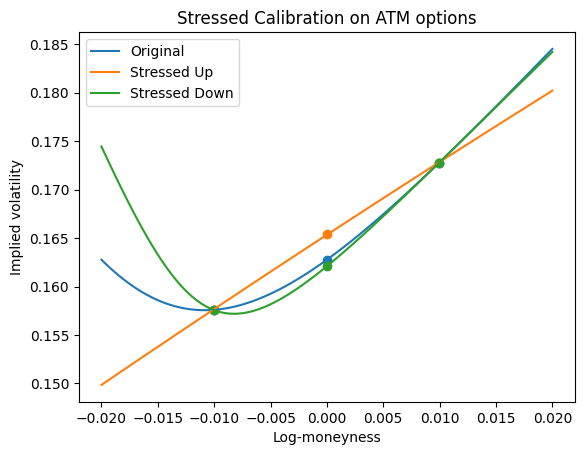

In [307]:
x_axis = np.linspace(-0.02, 0.02, 100)

fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Stressed Calibration on ATM options")
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par)))
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par_up)))
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par_down)))
ax.legend(["Original", "Stressed Up", "Stressed Down"])
ax.scatter(log_moneyness, np.sqrt(at_the_money_variance))
ax.scatter(log_moneyness, np.sqrt(stressed_variance_up))
ax.scatter(log_moneyness, np.sqrt(stressed_variance_down))
plt.show()

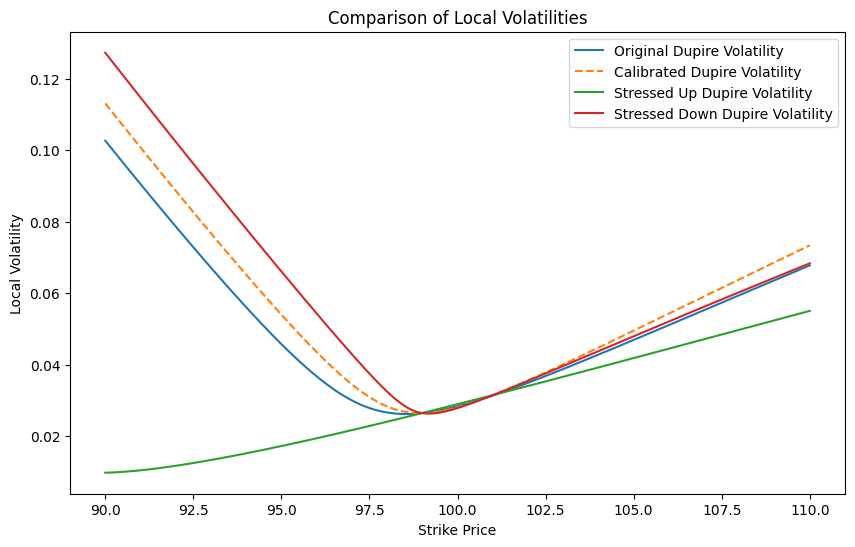

In [308]:
calibrated_SVI_implied_vols_up = [np.sqrt(SVI_func(np.log(k / spot), calibrated_par_up)) for k in strike_grid]

calibrated_dupire_vols_up = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, calibrated_SVI_implied_vols_up[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    calibrated_dupire_vols_up.append(vol)

calibrated_SVI_implied_vols_down = [np.sqrt(SVI_func(np.log(k / spot), calibrated_par_down)) for k in strike_grid]

calibrated_dupire_vols_down = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, calibrated_SVI_implied_vols_down[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    calibrated_dupire_vols_down.append(vol)

plt.figure(figsize=(10, 6))
plt.plot(strike_grid, dupire_vols, label="Original Dupire Volatility")
plt.plot(strike_grid, calibrated_dupire_vols, label="Calibrated Dupire Volatility", linestyle='--')
plt.plot(strike_grid, calibrated_dupire_vols_up, label="Stressed Up Dupire Volatility")
plt.plot(strike_grid, calibrated_dupire_vols_down, label="Stressed Down Dupire Volatility")
plt.xlabel("Strike Price")
plt.ylabel("Local Volatility")
plt.title("Comparison of Local Volatilities")
plt.legend()
plt.show()

## Pricing with Heston Model
##### Normal random number generator using Box-Muller trick

In [7]:
def gauss(n_steps, correlation):
    Z = np.zeros(shape=(2, n_steps))
    u = np.random.uniform(size=(2, n_steps))
    Z[0, :] = np.sqrt(-2 * np.log(u[0, :])) * np.cos(2 * np.pi * u[1, :])
    Z[1, :] = np.sqrt(-2 * np.log(u[0, :])) * np.sin(2 * np.pi * u[1, :])

    Z[1, :] = correlation * Z[0, :] + np.sqrt(1 - correlation**2) * Z[1, :]
    return Z

#### Pricing function using Monte Carlo simulations

In [310]:
def Heston_price(spot, strike, maturity, r, mp, n_sim, n_steps):
    # Initialize the arrays
    prices = np.zeros((n_sim, n_steps + 1))
    variances = np.zeros((n_sim, n_steps + 1))

    prices[:, 0] = spot
    variances[:, 0] = mp["v0"]

    # Initialize starting variables
    dt = float(maturity) / n_steps

    S_t = spot
    v_t = mp["v0"]

    # Simulation
    for t in range(1, n_steps + 1):
        # Generate two correlated normal random vectors with mean = (0, ... , 0)
        # and sigma = sqrt(dt) * Identity_matrix
        Z = gauss(n_sim, mp["correlation"])

        # Compute the next value and save it
        prev_v = v_t
        v_t = np.abs(v_t + mp["kappa"] * (mp["theta"] - v_t) * dt + mp["vol_of_vol"] * np.sqrt(v_t * dt) * Z[1, :])
        S_t = S_t * np.exp((r - prev_v * 0.5) * dt + np.sqrt(prev_v * dt) * Z[0, :])

        prices[:, t] = S_t
        variances[:, t] = v_t
    
    # Compute the price of the option
    payoffs = np.maximum(prices[:, -1] - strike, 0)
    average_payoff = np.mean(payoffs)
    option_price = average_payoff * np.exp(-r * maturity)

    # Compute the devstd of the price
    devstd = np.std(payoffs)
    option_devstd = devstd * np.exp(-2 * r * maturity) / np.sqrt(n_sim)
    
    return option_price, option_devstd

# Example of pricing with Heston model
heston_params = {'v0': 0.04, 'kappa': 2., 'theta': 0.04, 'vol_of_vol': 0.5, 'correlation': -0.5}

print(f'Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%')
price, devstd= Heston_price(100, 100, 1, risk_free_rate, heston_params, 10000, 252)
print(f'Option price: {price}  |  Devstd of the simulation: {devstd}')

Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%
Option price: 7.347053383671259  |  Devstd of the simulation: 0.10742681302644316


## Estimation of Heston parameters
#### Simulated annealing (adapted for Heston pricing)

In [311]:
# Modified simulated annealing to estimate the parameters of traditional Heston model 
def H_simulated_annealing(x_data, y_data, initial_guess, initial_T, max_iterations):
    # Generate the initial state and compute the initial energy
    new_parameters = initial_guess

    previous_energy = compute_energy_with_distortion(x_data, new_parameters, y_data, 20)

    optimal_parameters = new_parameters.copy()
    iteration = 1
    T = initial_T

    # While we are above the minimum temperature
    while iteration < max_iterations:

        # Generate a new state randomly
        n = random.randint(1, 5)

        if n == 1:
            # Change v0
            new_parameters["v0"] = np.abs(optimal_parameters["v0"] + random.uniform(-0.01, 0.01))
        elif n == 2:
            # Change kappa
            new_parameters["kappa"] = optimal_parameters["kappa"] + random.uniform(-0.2, 0.2)
        elif n == 3:
            # Change theta
            new_parameters["theta"] = np.abs(optimal_parameters["theta"] + random.uniform(-0.01, 0.01))
        elif n == 4:
            # Change vol_of_vol
            new_parameters["vol_of_vol"] = np.abs(optimal_parameters["vol_of_vol"] + random.uniform(-0.2, 0.2))
        elif n == 5:
            # Change correlation
            new_parameters["correlation"] = optimal_parameters["correlation"] + random.uniform(-0.01, 0.01)
            if np.abs(new_parameters["correlation"]) > 1:
                new_parameters["correlation"] = random.uniform(-1, 1)

        # Compute the energy of the new state
        new_energy = compute_energy_with_distortion(x_data, new_parameters, y_data, 20)
        delta_energy = new_energy - previous_energy

        # If the new state has a lower energy than the previous one, save it
        if acceptance_function(T, delta_energy):
            optimal_parameters = new_parameters.copy()
            previous_energy = new_energy
            print(f'Iteration: {iteration}  |  Best Energy: {pow(previous_energy, 20):.3}  |  Temperature: {T:.3e}', end="\r")

        # Reduce the temperature and increment iteration
        T = initial_T / iteration
        iteration += 1

    return optimal_parameters

# Computes the energy of the state. In this case the energy function
# (the function that should be minimized) is the sum of squared errors
def compute_energy_with_distortion(x_data, parameters, y_data, beta):
    # Simulate paths
    estimate = np.zeros(shape=len(x_data))
    for i in range(len(x_data)):
        estimate[i] = Heston_price(spot, x_data[i], 1, risk_free_rate, parameters, 10000, 252)[0]

    energy = sum_of_err_squared(y_data, estimate)
    distorted_energy = pow(energy, 1/beta)
    return distorted_energy

# This function decides if the new state should be accepted or refuted
# according to simulated annealing decision rule
def acceptance_function(T, delta_energy):
    if delta_energy < 0:
        return True
    else:
        r = random.uniform(0, 1)

        if T < 1E-6:
            return False

        if r < np.exp(-delta_energy / T):
            return True
        else:
            return False

# Returns the sum of the squared errors
def sum_of_err_squared(true_data, estimated_data):
    diff = [(elem1 - elem2)**2 for elem1, elem2 in zip(true_data, estimated_data)]
    s = sum(diff)
    return s

#### Estimation of Heston parameters

{'v0': 0.02519807620845603, 'kappa': -0.04433030211963476, 'theta': 0.04743510486208046, 'vol_of_vol': 0.0301804405667261, 'correlation': 0.8235665363361404}


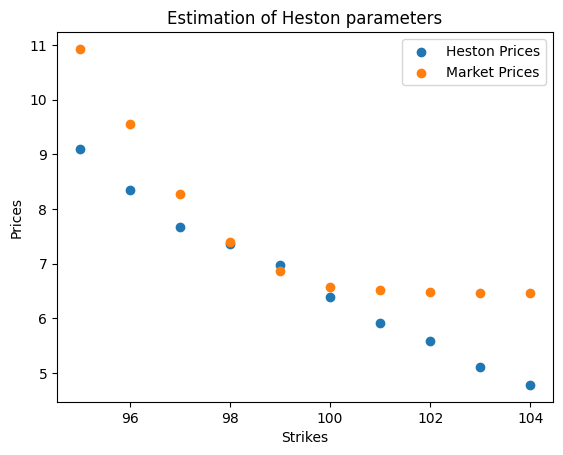

In [312]:
# Estimation of Heston parameters
# WARNING: takes 6-7 minutes
if False:
    initial_guess = {'v0': 0.02519807620845603, 'kappa': -0.04433030211963476, 'theta': 0.04743510486208046, 'vol_of_vol': 0.0301804405667261, 'correlation': 0.8235665363361404}
    best_heston_par = H_simulated_annealing(strikes, prices, initial_guess, 1, 1E2)
else:
    best_heston_par = {'v0': 0.02519807620845603, 'kappa': -0.04433030211963476, 'theta': 0.04743510486208046, 'vol_of_vol': 0.0301804405667261, 'correlation': 0.8235665363361404}

# Pricing
Heston_prices = [Heston_price(spot, k, 1, risk_free_rate, best_heston_par, 10000, 252)[0] for k in strikes]

# Plot the results
print(best_heston_par)
fig, ax = plt.subplots()
ax.set_title("Estimation of Heston parameters")
ax.scatter(strikes, Heston_prices)
ax.scatter(strikes, prices)
ax.set_xlabel("Strikes")
ax.set_ylabel("Prices")
ax.legend(["Heston Prices", "Market Prices"])

plt.show()

## Calibration of Heston parameters

{'v0': 0.09445133526000424, 'kappa': 5.746537158065592, 'theta': 0.01693029484470497, 'vol_of_vol': 0.5766083138315357, 'correlation': -0.6221760626253413}


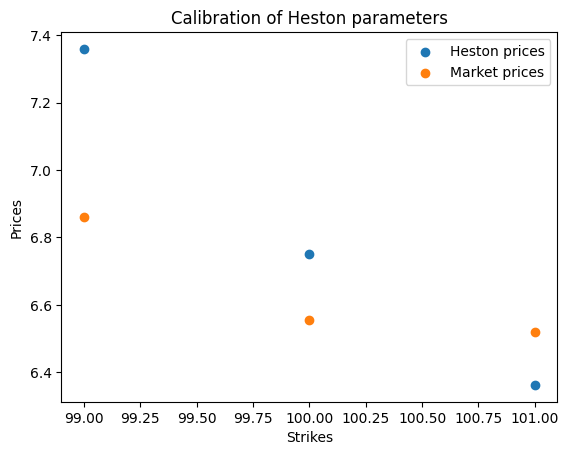

In [313]:
# Calibration of Heston parameters
if False:
    initial_guess = {'v0': 0.07189878391818576, 'kappa': 5.434674133780668, 'theta': 0.012134829953852507, 'vol_of_vol': 0.8385665667334575, 'correlation': -0.6406367865612076}
    calibrated_heston_par = H_simulated_annealing(at_the_money_strikes[0::2], at_the_money_prices[0::2], initial_guess, 1, 1E2)
else:
    calibrated_heston_par = {'v0': 0.09445133526000424, 'kappa': 5.746537158065592, 'theta': 0.01693029484470497, 'vol_of_vol': 0.5766083138315357, 'correlation': -0.6221760626253413}
print(calibrated_heston_par)

# Compute the prices
Heston_prices = [Heston_price(spot, k, 1, risk_free_rate, calibrated_heston_par, 10000, 252)[0] for k in at_the_money_strikes]
smile = [get_implied_vol(spot, k, 1, risk_free_rate, 0.2, p) for k, p in zip(at_the_money_strikes, Heston_prices)]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(at_the_money_strikes, Heston_prices)
ax.scatter(at_the_money_strikes, at_the_money_prices)
ax.set_title("Calibration of Heston parameters")
ax.set_xlabel("Strikes")
ax.set_ylabel("Prices")
ax.legend(["Heston prices", "Market prices"])

plt.show()

## Stressed Heston pricing

In [314]:
min_price, max_price = find_arbitrage_free_prices(prices, strike_index=5, step_size=0.001, range_size=0.05)

print(f"Min price for arbitrage-free condition: {min_price}")
print(f"Max price for arbitrage-free condition: {max_price}")

Min price for arbitrage-free condition: 6.55368
Max price for arbitrage-free condition: 6.6852800000000006


#### Calibration with upward and downward stress

In [315]:
stressed_prices_up = prices[:]
stressed_prices_up[5] = max_price
stressed_prices_down = prices[:]
stressed_prices_down[5] = min_price

at_the_money_strikes = strikes[4:7]
at_the_money_prices_up = stressed_prices_up[4:7]
at_the_money_prices_down = stressed_prices_down[4:7]

initial_guess = calibrated_heston_par
calibrated_heston_par_up = H_simulated_annealing(at_the_money_strikes, at_the_money_prices_up, initial_guess, 1, 1E2)
calibrated_heston_par_down = H_simulated_annealing(at_the_money_strikes, at_the_money_prices_down, initial_guess, 1, 1E2)
print(calibrated_heston_par_up)
print(calibrated_heston_par_down)

{'v0': 0.08448490782597548, 'kappa': 5.842519726787449, 'theta': 0.020189022038518058, 'vol_of_vol': 0.726178768926923, 'correlation': -0.5881449298849424}
{'v0': 0.09941109124690731, 'kappa': 5.824048181258712, 'theta': 0.009379489989846399, 'vol_of_vol': 0.38833642766792764, 'correlation': -0.5609814545655013}


[7.379269933576519, 7.172504714742854, 6.418731330831529]
[6.751067497679063, 6.237471482276982, 5.636394736112391]


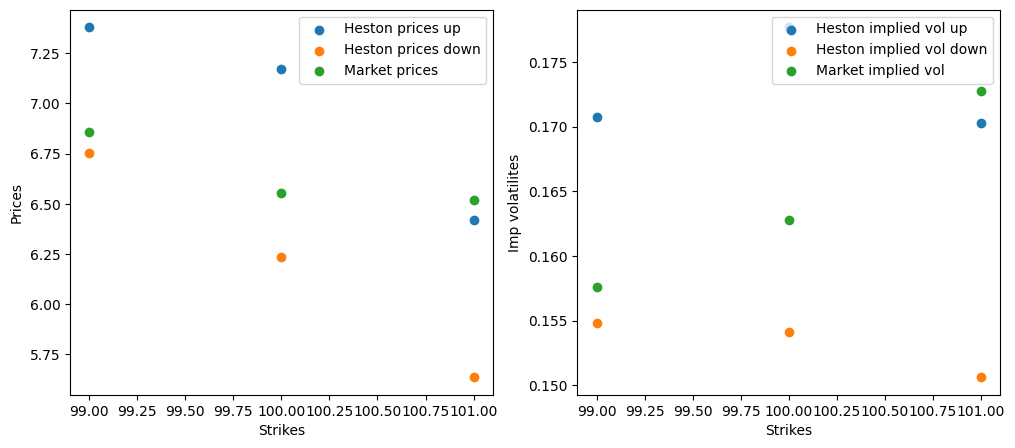

In [ ]:
# Compute the prices
Heston_prices_up = [Heston_price(spot, k, 1, risk_free_rate, calibrated_heston_par_up, 10000, 252)[0] for k in at_the_money_strikes]
Heston_prices_down = [Heston_price(spot, k, 1, risk_free_rate, calibrated_heston_par_down, 10000, 252)[0] for k in at_the_money_strikes]
smile_up = [get_implied_vol(spot, k, 1, risk_free_rate, 0.2, p) for k, p in zip(at_the_money_strikes, Heston_prices_up)]
smile_down = [get_implied_vol(spot, k, 1, risk_free_rate, 0.2, p) for k, p in zip(at_the_money_strikes, Heston_prices_down)]

print(Heston_prices_up)
print(Heston_prices_down)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(at_the_money_strikes, Heston_prices_up)
axs[0].scatter(at_the_money_strikes, Heston_prices_down)
axs[0].scatter(at_the_money_strikes, at_the_money_prices)
axs[0].set_xlabel("Strikes")
axs[0].set_ylabel("Prices")
axs[0].legend(["Heston prices up", "Heston prices down", "Market prices"])

axs[1].scatter(at_the_money_strikes, smile_up)
axs[1].scatter(at_the_money_strikes, smile_down)
axs[1].scatter(at_the_money_strikes, np.sqrt(at_the_money_variance))
axs[1].set_xlabel("Strikes")
axs[1].set_ylabel("Imp volatilites")
axs[1].legend(["Heston implied vol up", "Heston implied vol down", "Market implied vol"])

plt.show()

## Fractional Heston Model
#### Implementation of Fractional Brownian motion

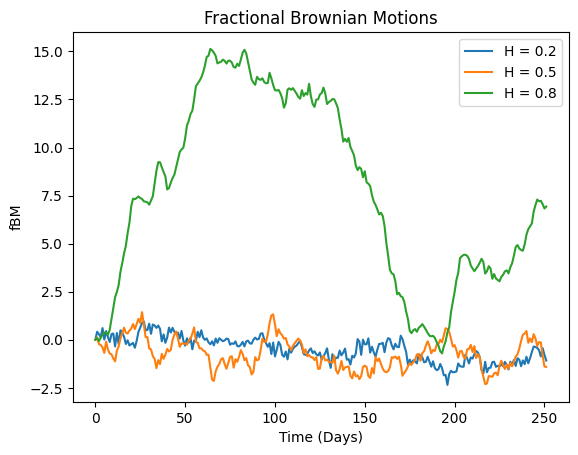

In [12]:
def build_covariance_matrix(sigma, hurst, n_steps):
    cov = np.zeros(shape=(n_steps, n_steps))
    for i in range(n_steps):
        for j in range(n_steps):
            cov[i, j] = ((i + 1)**(2 * hurst) + (j + 1)**(2 * hurst) - np.abs(i - j)**(2 * hurst)) * sigma**2 * 0.5
    return cov

def Cholesky_decomposition(M):
    cholesky = np.zeros(shape=M.shape)

    # Compute the first column of the matrix
    cholesky[0, 0] = np.sqrt(M[0, 0])
    cholesky[1:, 0] = M[1:, 0] / cholesky[0, 0]

    # For every other column
    for i in range(1, M.shape[0]):
        # Compute the diagonal element
        sum = 0
        for j in range(i):
            sum += cholesky[i, j]**2
        cholesky[i, i] = np.sqrt(M[i, i] - sum)

        # If we have not arrive at the last row, compute
        # the rest of the column
        if (i + 1) < M.shape[0]:
            for j in range(i + 1, M.shape[0]):
                sum = 0
                for p in range(i):
                    sum += cholesky[i, p] * cholesky[j, p]
                cholesky[j, i] = (M[j, i] - sum) / cholesky[i, i]
    return cholesky

def generate_fBM_path(volatility, hurst, n_steps):
    Y = np.zeros(n_steps)
    Y[0] = 0

    cov = build_covariance_matrix(volatility, hurst, n_steps - 1)
    correlation = Cholesky_decomposition(cov)

    Z = gauss(n_steps - 1, 0)[0, :]
    Y[1:] = correlation.dot(Z)
    return Y

# Example of fractional Brownian motion
Y1 = generate_fBM_path(np.sqrt(0.1), 0.2, 252)
Y2 = generate_fBM_path(np.sqrt(0.1), 0.5, 252)
Y3 = generate_fBM_path(np.sqrt(0.1), 0.8, 252)

fig, ax = plt.subplots()
ax.set_title("Fractional Brownian Motions")
ax.set_xlabel("Time (Days)")
ax.set_ylabel("fBM")
ax.plot([x for x in range(len(Y1))], Y1)
ax.plot([x for x in range(len(Y2))], Y2)
ax.plot([x for x in range(len(Y3))], Y3)
ax.legend(["H = 0.2", "H = 0.5", "H = 0.8"])
plt.show()

#### Fractional Heston pricer

In [11]:
# Fractional Heston pricer
def fractional_Heston_price(spot, strike, maturity, r, mp, n_sim, n_steps):
    # Initialize the arrays
    prices = np.zeros((n_sim, n_steps + 1))
    variances = np.zeros((n_sim, n_steps + 1))

    prices[:, 0] = spot
    variances[:, 0] = mp["v0"]

    # Initialize starting variables
    dt = float(maturity) / n_steps

    S_t = spot
    v_t = mp["v0"]

    fBM = np.zeros(shape=(n_sim, n_steps))
    Z = np.zeros(shape=(n_sim, n_steps))

    for n in range(n_sim):
        fBM[n, :] = generate_fBM_path(mp["v0"], mp['H'], n_steps)
        Z[n, :] = gauss(n_steps, 0)[0, :]

    # Simulation
    for t in range(1, n_steps + 1):
        # Compute the next value and save it
        prev_v = v_t
        v_t = np.abs(v_t + mp["kappa"] * (mp["theta"] - v_t) * dt + mp["vol_of_vol"] * np.sqrt(v_t * dt) * fBM[:, t - 1])
        S_t = S_t * np.exp((r - prev_v * 0.5) * dt + np.sqrt(prev_v * dt) * Z[:, t - 1])

        prices[:, t] = S_t
        variances[:, t] = v_t
    
    # Compute the price of the option
    payoffs = np.maximum(prices[:, -1] - strike, 0)
    average_payoff = np.mean(payoffs)
    option_price = average_payoff * np.exp(-r * maturity)

    # Compute the devstd of the price
    devstd = np.std(payoffs)
    option_devstd = devstd * np.exp(-2 * r * maturity) / np.sqrt(n_sim)
    
    return option_price, option_devstd

# Example of pricing with fractional Heston model
heston_params = {'v0': 0.04, 'kappa': 2., 'theta': 0.04, 'vol_of_vol': 0.5, 'correlation': -0.5, 'H': 0.7}

print(f'Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%')
price, devstd= fractional_Heston_price(100, 100, 1, risk_free_rate, heston_params, 500, 70)
print(f'Option price: {price}  |  Devstd of the simulation: {devstd}')

Spot: 100  |  Strike: 100  |  Maturity: 1y  | risk free rate: 0.2%
Option price: 9.00339995338128  |  Devstd of the simulation: 1.0459969125857558


#### Simulated Annealing (adapted for fractional Heston pricing)

In [4]:
# Modified simulated annealing to estimate the parameters of fractional Heston model 
def fracH_simulated_annealing(x_data, y_data, initial_guess, initial_T, max_iterations):
    # Generate the initial state and compute the initial energy
    new_parameters = initial_guess

    previous_energy = compute_energy_with_distortion(x_data, new_parameters, y_data, 20)

    optimal_parameters = new_parameters.copy()
    iteration = 1
    T = initial_T

    # While we are above the minimum temperature
    while iteration < max_iterations:

        # Generate a new state randomly
        n = random.randint(1, 6)

        if n == 1:
            # Change v0
            new_parameters["v0"] = np.abs(optimal_parameters["v0"] + random.uniform(-0.01, 0.01))
        elif n == 2:
            # Change kappa
            new_parameters["kappa"] = optimal_parameters["kappa"] + random.uniform(-0.2, 0.2)
        elif n == 3:
            # Change theta
            new_parameters["theta"] = np.abs(optimal_parameters["theta"] + random.uniform(-0.01, 0.01))
        elif n == 4:
            # Change vol_of_vol
            new_parameters["vol_of_vol"] = np.abs(optimal_parameters["vol_of_vol"] + random.uniform(-0.2, 0.2))
        elif n == 5:
            # Change correlation
            new_parameters["correlation"] = optimal_parameters["correlation"] + random.uniform(-0.01, 0.01)
            if np.abs(new_parameters["correlation"]) > 1:
                new_parameters["correlation"] = random.uniform(-1, 1)
        elif n == 6:
            new_parameters["H"] = np.abs(optimal_parameters["H"] + random.uniform(-0.05, 0.05))

        # Compute the energy of the new state
        new_energy = compute_energy_with_distortion(x_data, new_parameters, y_data, 20)
        delta_energy = new_energy - previous_energy

        # If the new state has a lower energy than the previous one, save it
        if acceptance_function(T, delta_energy):
            optimal_parameters = new_parameters.copy()
            previous_energy = new_energy
            print(f'{optimal_parameters}\nIteration: {iteration}  |  Best Energy: {pow(previous_energy, 20):.3}  |  Temperature: {T:.3e}', end="\r")

        # Reduce the temperature and increment iteration
        T = initial_T / iteration
        iteration += 1

    return optimal_parameters

# Computes the energy of the state. In this case the energy function
# (the function that should be minimized) is the sum of squared errors
def compute_energy_with_distortion(x_data, parameters, y_data, beta):
    # Simulate paths
    estimate = np.zeros(shape=len(x_data))
    for i in range(len(x_data)):
        estimate[i] = fractional_Heston_price(spot, x_data[i], 1, risk_free_rate, parameters, 100, 64)[0]

    energy = sum_of_err_squared(y_data, estimate)
    distorted_energy = pow(energy, 1/beta)
    return distorted_energy

# This function decides if the new state should be accepted or refuted
# according to simulated annealing decision rule
def acceptance_function(T, delta_energy):
    if delta_energy < 0:
        return True
    else:
        r = random.uniform(0, 1)

        if T < 1E-6:
            return False

        if r < np.exp(-delta_energy / T):
            return True
        else:
            return False

# Returns the sum of the squared errors
def sum_of_err_squared(true_data, estimated_data):
    diff = [(elem1 - elem2)**2 for elem1, elem2 in zip(true_data, estimated_data)]
    s = sum(diff)
    return s

#### Estimation of fractional Heston parameters

{'v0': 0.04304523952240605, 'kappa': 2.3041440257397383, 'theta': 0.029196959860739904, 'vol_of_vol': 0.03821133858125292, 'correlation': -0.5044209067538645, 'H': 0.33342667886836974}


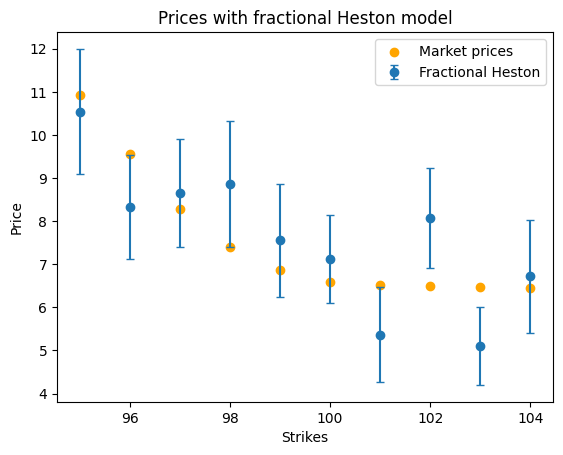

In [10]:
# Estimation
if False:
    initial_guess = {'v0': 0.06304523952240605, 'kappa': 2.3041440257397383, 'theta': 0.029196959860739904, 'vol_of_vol': 0.03821133858125292, 'correlation': -0.5044209067538645, 'H': 0.33342667886836974}
    frac_heston_params = fracH_simulated_annealing(strikes, prices, frac_heston_params, 2, 10)
else:
    frac_heston_params = {'v0': 0.04304523952240605, 'kappa': 2.3041440257397383, 'theta': 0.029196959860739904, 'vol_of_vol': 0.03821133858125292, 'correlation': -0.5044209067538645, 'H': 0.33342667886836974}

res = [fractional_Heston_price(spot, k, 1, risk_free_rate, frac_heston_params, 100, 70) for k in strikes]
fH_prices = [r[0] for r in res]
fH_devstd = [r[1] for r in res]

# Print the results
print(frac_heston_params)
fig, ax = plt.subplots()
ax.set_title("Prices with fractional Heston model")
ax.set_xlabel("Strikes")
ax.set_ylabel("Price")
ax.errorbar(strikes, fH_prices, yerr=fH_devstd, fmt='o', capsize=3)
ax.scatter(strikes, prices, color='orange')
ax.legend(["Market prices", "Fractional Heston"])
plt.show()